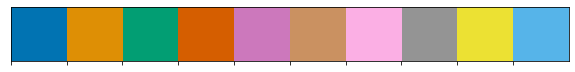

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes
%matplotlib inline

from sklearn.svm import SVC,LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.externals import joblib

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc

from scipy.stats import skew, kurtosis

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#plt.style.use('dark_background')
current_palette = sns.color_palette('colorblind')
sns.palplot(current_palette)

# Import Data

In [3]:
data_set = pd.read_csv('train_ctrUa4K.csv')

In [5]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
data_set.LoanAmount = data_set.LoanAmount*1000

In [7]:
data_set.Loan_Status.value_counts(normalize = True).reset_index()

,index,Loan_Status
0,Y,0.687296
1,N,0.312704


<AxesSubplot:xlabel='index', ylabel='Loan_Status'>

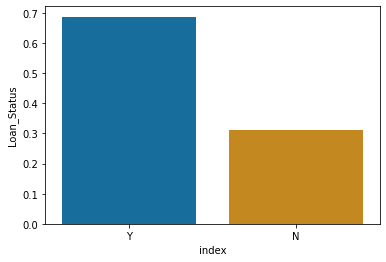

In [8]:
sns.barplot(data = data_set.Loan_Status.value_counts(normalize = True).reset_index(),
            x = 'index',
            y = 'Loan_Status',
            palette=current_palette)

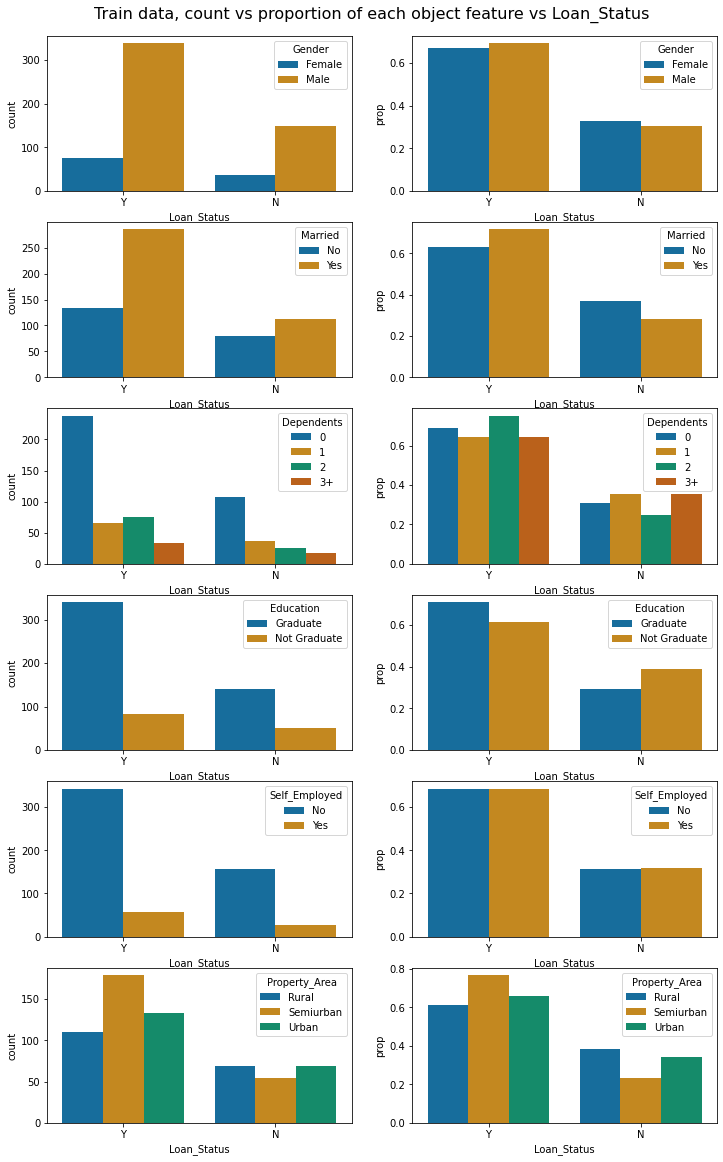

In [9]:
def prop_check(data):
    f, axes = plt.subplots(6,2,figsize= (12,20))
    plt.suptitle('Train data, count vs proportion of each object feature vs Loan_Status', size =16, y = 0.9)
    col = data.columns[1:data.shape[1]-1]
    r = 0
    for i in col:
        if (data.dtypes == 'object')[i]:        
            data_prop = (data['Loan_Status']
                          .groupby(data[i])
                          .value_counts(normalize = True)
                          .rename('prop')
                          .reset_index())
            sns.countplot(data = data, 
                          x ='Loan_Status', 
                          hue = i, 
                          ax = axes[r,0], 
                          hue_order=data_prop[i].unique(), 
                          palette=current_palette)
            sns.barplot(data = data_prop, 
                        x = 'Loan_Status', 
                        y = 'prop',
                        hue = i,
                        ax = axes[r,1],
                        palette=current_palette)
            r = r+1
prop_check(data_set)

In [10]:
def make_index(df):
    df.set_index('Loan_ID', inplace=True)
    return df
data_set = make_index(data_set)

In [11]:
data_set.dropna(inplace=True)

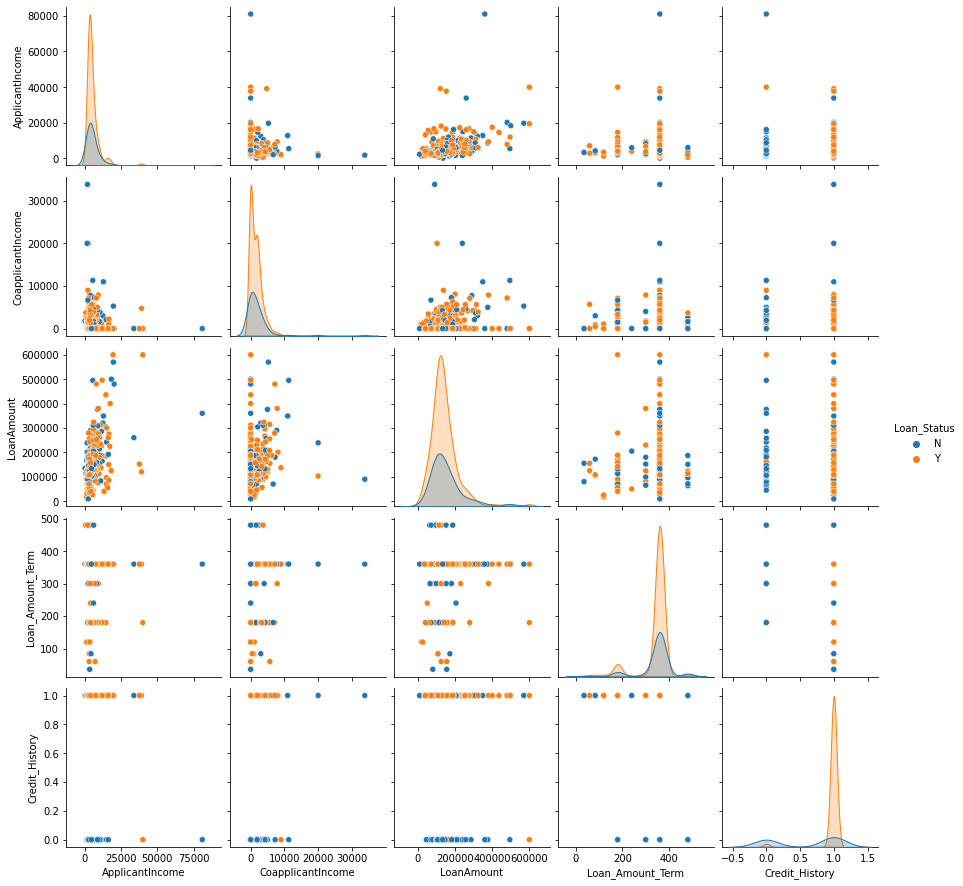

In [13]:
sns.pairplot(data_set, hue = 'Loan_Status')

# Categorizing numerically object columns by column name

In [14]:
def categorize(df):
    df.Gender.replace({'Male': 1, 'Female': 0}, inplace = True)
    df.Married.replace({'Yes': 1, 'No': 0}, inplace = True)
    df.Education.replace({'Graduate': 1, 'Not Graduate': 0}, inplace = True)
    df.Self_Employed.replace({'Yes': 1, 'No': 0}, inplace = True)
    df = df.join(pd.get_dummies(df.Dependents, prefix='Dependents'))
    df.drop(columns= ['Dependents', 'Dependents_3+'], inplace=True)
    df = df.join(pd.get_dummies(df.Property_Area, prefix='Property_Area'))
    df.drop(columns= ['Property_Area', 'Property_Area_Rural'], inplace=True)
    return df


In [15]:
data_set = categorize(data_set)

In [16]:
data_set.Loan_Status.replace({'Y': 1, 'N':0}, inplace=True)

# Model selection

# Adding new features

naive estimation of monthly loan return (LoanAmount/Loan_Amount_Term) normalized and with ln() let us get the distribution as closer as can be to normal distribution
total income (ApplicantIncome + CoaplicantIncome) normlized and with ln() let us get the distribution as closer as can be to normal distribution

In [18]:
def add_feat(df):
    ln_monthly_return = np.log(df.LoanAmount/df.Loan_Amount_Term)
    df['ln_monthly_return'] = (ln_monthly_return - np.mean(ln_monthly_return))/(np.std(ln_monthly_return)/np.sqrt(len(ln_monthly_return)))
    
    ln_total_monthly_income = np.log(df.ApplicantIncome + df.CoapplicantIncome)
    df['ln_total_income'] = (ln_total_monthly_income - np.mean(ln_total_monthly_income))/(np.std(ln_total_monthly_income)/np.sqrt(len(ln_total_monthly_income)))
    
    ln_LoanAmount = np.log(1000*df.LoanAmount)
    df['ln_LoanAmount'] = (ln_LoanAmount - np.mean(ln_LoanAmount))/(np.std(ln_LoanAmount)/np.sqrt(len(ln_LoanAmount)))
    
    
    return df

In [19]:
data_set = add_feat(data_set)

In [20]:
def norm_plt(df):
    f, axes = plt.subplots(3,2,figsize= (12,15),squeeze=False)

    ######total income########
    sns.distplot(df.ln_total_income
                 ,ax=axes[0,0]).set_title('ln(total_income) norm distribution')
    #axes[0,0].set_xlim(-100,100)
    axes[0,0].text(0.03, 0.85,
                   'skew: {0:0.2}\nkurtosis: {1:0.2f}'
                   .format(skew(df.ln_total_income),
                                          kurtosis(df.ln_total_income)),
                   horizontalalignment='left',
                   verticalalignment='bottom',
                   transform=axes[0,0].transAxes,
                   bbox={'facecolor': 'white'})
    sns.distplot((df.ApplicantIncome+df.CoapplicantIncome),
                 ax=axes[0,1]).set_title('total_income distribution')
    axes[0,1].text(0.7, 0.85,
                   'skew: {0:0.2f}\nkurtosis: {1:0.2f}'
                   .format(skew(df.ApplicantIncome+df.CoapplicantIncome),
                           kurtosis(df.ApplicantIncome+df.CoapplicantIncome)),
                   horizontalalignment='left',
                   verticalalignment='bottom',
                   transform=axes[0,1].transAxes,
                   bbox={'facecolor': 'white'})

    #######monthly return###########
    sns.distplot(df.ln_monthly_return,
                 ax=axes[1,0]).set_title('ln(monthly_return) norm distribution')
    #axes[1,0].set_xlim(-100,100)
    axes[1,0].text(0.03, 0.85,
                   'skew: {0:0.2}\nkurtosis: {1:0.2f}'
                   .format(skew(df.ln_monthly_return),
                           kurtosis(df.ln_monthly_return)),
                   horizontalalignment='left',
                   verticalalignment='bottom',
                   transform=axes[1,0].transAxes,
                   bbox={'facecolor': 'white'})

    sns.distplot((1000*df.LoanAmount/df.Loan_Amount_Term),
                 ax=axes[1,1]).set_title('monthly_return distribution')
    axes[1,1].text(0.7, 0.85,
                   'skew: {0:0.2f}\nkurtosis: {1:0.2f}'
                   .format(skew(df.LoanAmount/df.Loan_Amount_Term),
                           kurtosis(df.LoanAmount/df.Loan_Amount_Term)),
                   horizontalalignment='left',
                   verticalalignment='bottom',
                   transform=axes[1,1].transAxes,
                   bbox={'facecolor': 'white'})

    ######norm ln_LoanAmount########
    sns.distplot(df.ln_LoanAmount
                 ,ax=axes[2,0]).set_title('ln(LoanAmount) norm distribution')
    #axes[2,0].set_xlim(-100,100)
    axes[2,0].text(0.03, 0.85,
                   'skew: {0:0.2}\nkurtosis: {1:0.2f}'
                   .format(skew(df.ln_LoanAmount),
                                          kurtosis(df.ln_LoanAmount)),
                   horizontalalignment='left',
                   verticalalignment='bottom',
                   transform=axes[2,0].transAxes,
                   bbox={'facecolor': 'white'})
    sns.distplot((df.LoanAmount),
                 ax=axes[2,1]).set_title('LoanAmount distribution')
    axes[2,1].text(0.7, 0.85,
                   'skew: {0:0.2f}\nkurtosis: {1:0.2f}'
                   .format(skew(df.LoanAmount),
                           kurtosis(df.LoanAmount)),
                   horizontalalignment='left',
                   verticalalignment='bottom',
                   transform=axes[2,1].transAxes,
                   bbox={'facecolor': 'white'})
    
    
    ####### adding grid to the graph#########
    for i in range(3):
        for j in range(2):
            axes[i,j].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

C:\Users\vaibhav\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vaibhav\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vaibhav\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

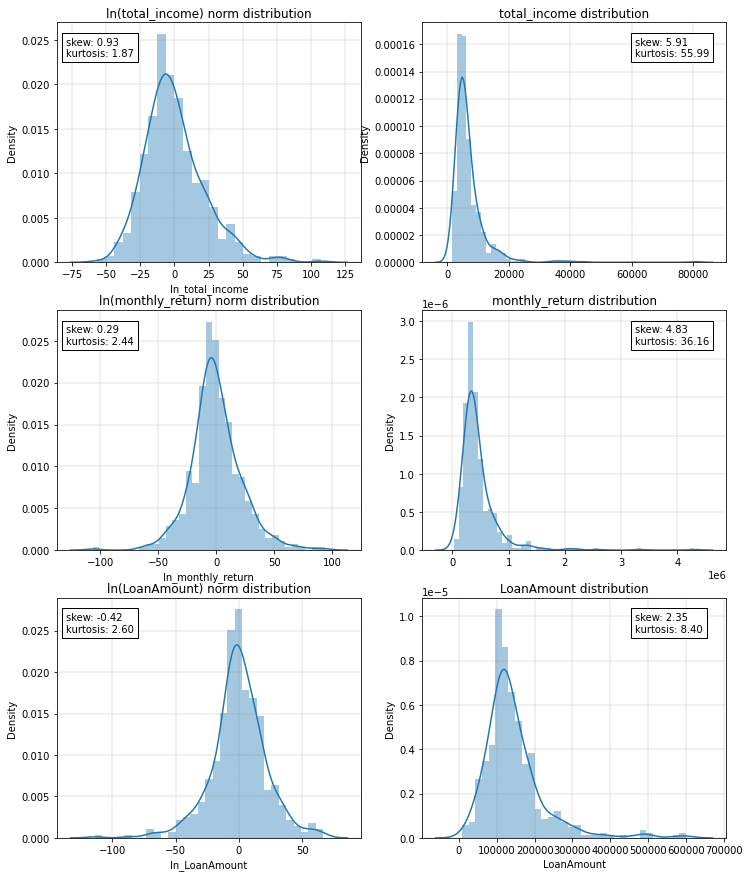

In [21]:
norm_plt(data_set)

In [22]:
dropit=['LoanAmount', 
        'Loan_Amount_Term', 
        'ApplicantIncome',
        'CoapplicantIncome',
        'Married',
        'Dependents_0',
        'Dependents_1',
        'Dependents_2']
data_set.drop(columns=dropit, 
           inplace=True)

1    0.691667
0    0.308333
Name: Loan_Status, dtype: float64

<AxesSubplot:xlabel='index', ylabel='Loan_Status'>

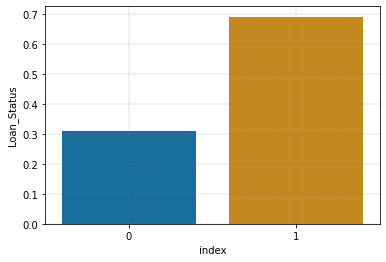

In [23]:
data_set['Loan_Status'].value_counts(normalize=True)
sns.barplot(data = data_set.Loan_Status.value_counts(normalize = True).reset_index(),
            x = 'index',
            y = 'Loan_Status',
            palette=current_palette)
plt.grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

# Classifiers optimization

In [24]:
def cv_check(X,y, CV):
    models = [
        RandomForestClassifier(criterion='gini',
                               n_estimators=50,
                               max_depth=11,
                               max_features=6,
                               random_state=42,
                               class_weight='balanced_subsample',
                               n_jobs=4),
        SVC(C=1, kernel='rbf', gamma='auto',random_state=42,class_weight='balanced'),
        LogisticRegression(solver='lbfgs',
                           multi_class='ovr',
                           max_iter=500,
                           C=1,
                           random_state=42,
                           class_weight='balanced'),
        GaussianNB(),
        #LinearSVC(C=1, 
        #         max_iter=500,
        #          random_state=0),
        DummyClassifier(strategy='most_frequent',random_state=42)
    ]

    entries = []
    
    for model in models:
        model_name = model.__class__.__name__
        print ("Currently fitting: {}".format(model_name))
        accuracies = cross_val_score(model,
                                     X,
                                     y, 
                                     scoring='roc_auc', cv=CV, n_jobs=4)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'roc_auc'])
        
    return cv_df

In [26]:
def cv_bp(cv_df, title, axes):
    axes.grid(b=True, 
              which='both', 
              axis='both', 
              color='grey', 
              linestyle = '--', 
              linewidth = '0.3')    
    sns.boxplot(x='model_name', 
                y='roc_auc', 
                data=cv_df, 
                width = 0.5, 
                ax=axes,
                palette=current_palette).set_title(title)
    sns.stripplot(x='model_name', 
                  y='roc_auc',
                  data=cv_df, 
                  size=5, jitter=True, 
                  edgecolor="grey", 
                  linewidth=1, 
                  ax=axes)
    plt.ylim(0.2,1)
    plt.savefig('{}.png'.format(title), format='png')
    plt.show()

Currently fitting: RandomForestClassifier
Currently fitting: SVC
Currently fitting: LogisticRegression
Currently fitting: GaussianNB
Currently fitting: DummyClassifier


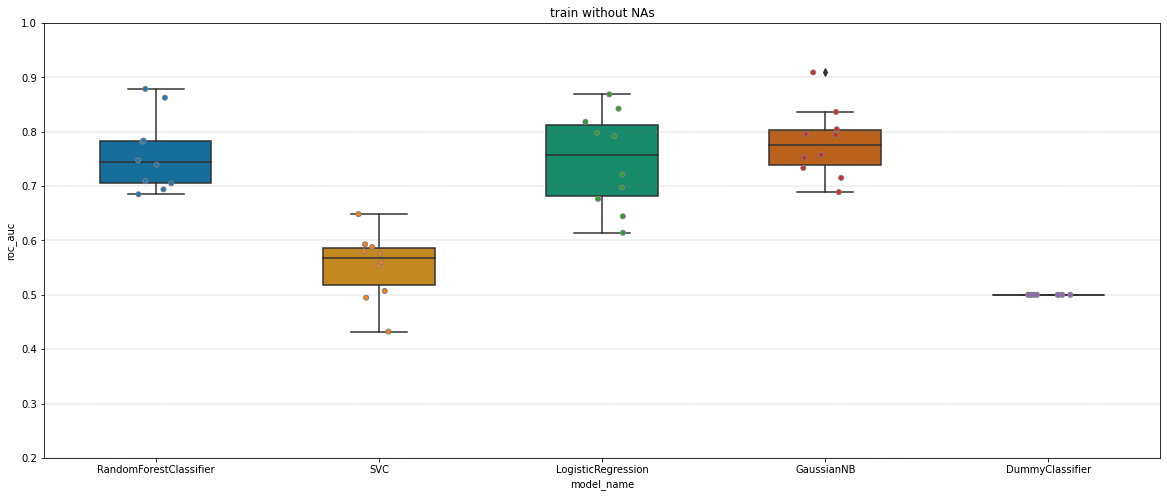

In [27]:
f, axes = plt.subplots(1,1,figsize= (20,8),squeeze=False, sharey=True)
cv_bp(cv_check(data_set.drop(['Loan_Status'],axis=1),
               data_set.Loan_Status,10), '{} without NAs'.format('train'),axes[0,0])

# RandomForest

In [44]:
def model_score(train, model, grid_values, scorers_list):
    X_train = train.drop(columns=['Loan_Status'])
    y_train = train['Loan_Status']
    
    clf_dict = {}
    
    for i, scorer in enumerate(scorers_list):
        clf_eval = GridSearchCV(model, param_grid=grid_values, scoring=scorer, cv=5, iid=False)
        clf_eval.fit(X_train,y_train)
        print('Grid best parameters for {0}: {1} scoring: {2}'
              .format(scorer, clf_eval.best_params_, round(clf_eval.best_score_,3)))
        clf_dict[scorer] = clf_eval
    return clf_dict

In [29]:
grid_values = {'max_features': [4, 5, 6, 7],
              'max_depth': [3, 7, 11, 13]}
scorers_list = ['accuracy','roc_auc','precision','recall', 'f1']

rf_cv = model_score(data_set,
            RandomForestClassifier(random_state=42, 
                                   n_jobs=4, 
                                   class_weight='balanced_subsample', 
                                   n_estimators=50), 
            grid_values, 
            scorers_list)

temp_df1 = pd.DataFrame()
for i in scorers_list:
      temp_df1[i]=rf_cv[i].cv_results_['mean_test_score'][rf_cv[i].cv_results_['param_max_features']==4]
temp_df1['max_depth'] = rf_cv['roc_auc'].cv_results_['param_max_depth'][rf_cv['roc_auc'].cv_results_['param_max_features']==4]
temp_df1.set_index('max_depth', inplace=True)
print('4:\n')
temp_df1

temp_df2 = pd.DataFrame()
for i in scorers_list:
      temp_df2[i]=rf_cv[i].cv_results_['mean_test_score'][rf_cv[i].cv_results_['param_max_features']==6]
temp_df2['max_depth'] = rf_cv['roc_auc'].cv_results_['param_max_depth'][rf_cv['roc_auc'].cv_results_['param_max_features']==6]
temp_df2.set_index('max_depth', inplace=True)
print('6:\n')
temp_df2

C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for accuracy: {'max_depth': 3, 'max_features': 7} scoring: 0.806


C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for roc_auc: {'max_depth': 3, 'max_features': 4} scoring: 0.769


C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for precision: {'max_depth': 11, 'max_features': 7} scoring: 0.821


C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for recall: {'max_depth': 3, 'max_features': 6} scoring: 0.949


C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for f1: {'max_depth': 3, 'max_features': 7} scoring: 0.871
4:



,accuracy,roc_auc,precision,recall,f1
max_depth,,,,,
3,0.795833,0.768789,0.800969,0.939937,0.864350
7,0.797917,0.746886,0.808251,0.930801,0.864661
11,0.797917,0.762878,0.811225,0.924695,0.863699
13,0.789583,0.762969,0.811146,0.909724,0.856749


6:



,accuracy,roc_auc,precision,recall,f1
max_depth,,,,,
3,0.804167,0.759422,0.804702,0.948892,0.870281
7,0.793750,0.764031,0.807332,0.924740,0.861394
11,0.787500,0.755998,0.811889,0.903573,0.854871
13,0.789583,0.759228,0.810717,0.909634,0.856963


# LogisticRegression

In [30]:
grid_values = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}
scorers_list = ['accuracy','roc_auc','precision','recall', 'f1']


lr_cv = model_score(data_set,
                    LogisticRegression(solver='liblinear',random_state=42, max_iter=500,
                                      class_weight='balanced'),
                    grid_values,
                    scorers_list)


temp_df1 = pd.DataFrame()
for i in scorers_list:
      temp_df1[i]=lr_cv[i].cv_results_['mean_test_score'][lr_cv[i].cv_results_['param_penalty']=='l1']
temp_df1['C'] = lr_cv['roc_auc'].cv_results_['param_C'][lr_cv['roc_auc'].cv_results_['param_penalty']=='l1']
temp_df1.set_index('C', inplace=True)
print('l1:\n')
temp_df1

temp_df2 = pd.DataFrame()
for i in scorers_list:
      temp_df2[i]=lr_cv[i].cv_results_['mean_test_score'][lr_cv[i].cv_results_['param_penalty']=='l2']
temp_df2['C'] = lr_cv['roc_auc'].cv_results_['param_C'][lr_cv['roc_auc'].cv_results_['param_penalty']=='l2']
temp_df2.set_index('C', inplace=True)
print('l2:\n')
temp_df2

C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for accuracy: {'C': 0.1, 'penalty': 'l1'} scoring: 0.788


C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for roc_auc: {'C': 10, 'penalty': 'l1'} scoring: 0.751


C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for precision: {'C': 10, 'penalty': 'l1'} scoring: 0.811


C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for recall: {'C': 0.1, 'penalty': 'l1'} scoring: 0.943
Grid best parameters for f1: {'C': 0.1, 'penalty': 'l1'} scoring: 0.859
l1:



C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


,accuracy,roc_auc,precision,recall,f1
C,,,,,
0.01,0.508333,0.516915,0.689499,0.521303,0.591382
0.10,0.787500,0.707039,0.791368,0.942967,0.859483
1.00,0.766667,0.750044,0.801230,0.889100,0.839506
10.00,0.762500,0.750968,0.810924,0.861918,0.833077
100.00,0.756250,0.750263,0.809447,0.852872,0.828031


l2:



,accuracy,roc_auc,precision,recall,f1
C,,,,,
0.01,0.747917,0.687532,0.790688,0.861872,0.822108
0.10,0.766667,0.730609,0.794526,0.897874,0.841103
1.00,0.768750,0.746310,0.800312,0.895070,0.841938
10.00,0.758333,0.750055,0.810028,0.855902,0.829666
100.00,0.758333,0.750261,0.810028,0.855902,0.829666


# SVC

In [31]:
grid_values = {'C': [1, 10],
              'gamma': [0.5, 0.7, 0.9, 0.95]}
scorers_list = ['accuracy','roc_auc','precision','recall', 'f1']


svc_cv = model_score(data_set,
                    SVC(random_state=42, class_weight='balanced',kernel='rbf'),
                    grid_values,
                    scorers_list)


temp_df1 = pd.DataFrame()
for i in scorers_list:
      temp_df1[i]=svc_cv[i].cv_results_['mean_test_score'][svc_cv[i].cv_results_['param_C']==1]
temp_df1['gamma'] = svc_cv['roc_auc'].cv_results_['param_gamma'][svc_cv['roc_auc'].cv_results_['param_C']==1]
temp_df1.set_index('gamma', inplace=True)
print('C=1:\n')
temp_df1

temp_df2 = pd.DataFrame()
for i in scorers_list:
      temp_df2[i]=svc_cv[i].cv_results_['mean_test_score'][svc_cv[i].cv_results_['param_C']==10]
temp_df2['gamma'] = svc_cv['roc_auc'].cv_results_['param_gamma'][svc_cv['roc_auc'].cv_results_['param_C']==10]
temp_df2.set_index('gamma', inplace=True)
print('C=10:\n')
temp_df2

C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for accuracy: {'C': 1, 'gamma': 0.9} scoring: 0.681


C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for roc_auc: {'C': 10, 'gamma': 0.95} scoring: 0.54


C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for precision: {'C': 1, 'gamma': 0.9} scoring: 0.69


C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for recall: {'C': 1, 'gamma': 0.9} scoring: 0.979
Grid best parameters for f1: {'C': 1, 'gamma': 0.9} scoring: 0.809
C=1:



C:\Users\vaibhav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


,accuracy,roc_auc,precision,recall,f1
gamma,,,,,
0.50,0.668750,0.516356,0.688067,0.951560,0.798517
0.70,0.679167,0.520430,0.689226,0.975758,0.807792
0.90,0.681250,0.536072,0.689912,0.978788,0.809302
0.95,0.681250,0.536078,0.689912,0.978788,0.809302


C=10:



,accuracy,roc_auc,precision,recall,f1
gamma,,,,,
0.50,0.668750,0.527600,0.687292,0.954591,0.799090
0.70,0.675000,0.531996,0.687882,0.969742,0.804787
0.90,0.679167,0.537030,0.689226,0.975758,0.807792
0.95,0.679167,0.539887,0.689226,0.975758,0.807792


# The following are the main functions to run each model evaluation in the chosen best values

In [32]:
def mod_eval(df,predictions, predprob, y_test, title):
    # prints confusion matrix heatmap    
    cm = confusion_matrix(df.Loan_Status[y_test.index], predictions)
    sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes']).set_title(title)
    plt.xlabel('Real')
    plt.ylabel('Predict')
    
    print(classification_report(df.Loan_Status[y_test.index], predictions))
    
    f, axes = plt.subplots(1,2,figsize= (20,6),squeeze=False)

    fpr, tpr, _ = roc_curve(df.Loan_Status[y_test.index], predprob[:,1])
    roc_auc = auc(fpr,tpr)
    axes[0,0].plot(fpr, tpr, lw=3)
    axes[0,0].set_title('{} ROC curve (area = {:0.2f})'.format(title, roc_auc))
    axes[0,0].set(xlabel='False Positive Rate',ylabel='True Positive Rate')
    axes[0,0].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

    precision, recall, thresholds = precision_recall_curve(y_test, predprob[:,1])
    best_index = np.argmin(np.abs(precision-recall)) # set the best index to be the minimum delta between precision and recall
    axes[0,1].plot(precision,recall)
    axes[0,1].set_title('{} Precision-Recall Curve'.format(title))
    axes[0,1].set(xlabel='Precision', ylabel='Recall', xlim=(0.4,1.05))
    axes[0,1].plot(precision[best_index],recall[best_index],'o',color='r')
    axes[0,1].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

In [33]:
def model_training(classifier,df):
    clf = classifier
    t=df.drop(columns=['Loan_Status'])
    X_train, X_test, y_train, y_tests = train_test_split(t,
                                                         df['Loan_Status'],
                                                         test_size=ts,
                                                         stratify=df['Loan_Status'])
    clf.fit(X_train, y_train)
    return clf

# Chosen values per model

In [34]:
#RandomForest
max_depth=11
max_features=6

In [35]:
#LogisticRegression
lr_C=0.1
penalty='l1'

In [36]:
#SVC
svc_C=1
gamma=0.9

In [37]:
#Test Size
ts = 0.333

# RandomForest

              precision    recall  f1-score   support

           0       0.90      0.76      0.82        49
           1       0.90      0.96      0.93       111

    accuracy                           0.90       160
   macro avg       0.90      0.86      0.88       160
weighted avg       0.90      0.90      0.90       160



,fi
Credit_History,0.278274
ln_total_income,0.252791
ln_monthly_return,0.174592
ln_LoanAmount,0.166502
Property_Area_Semiurban,0.036144
Gender,0.027970
Property_Area_Urban,0.025466
Self_Employed,0.021223
Education,0.017038


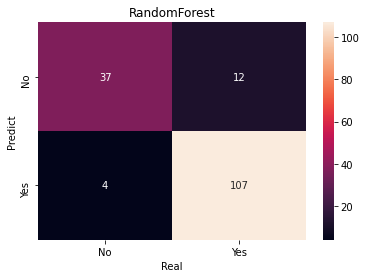

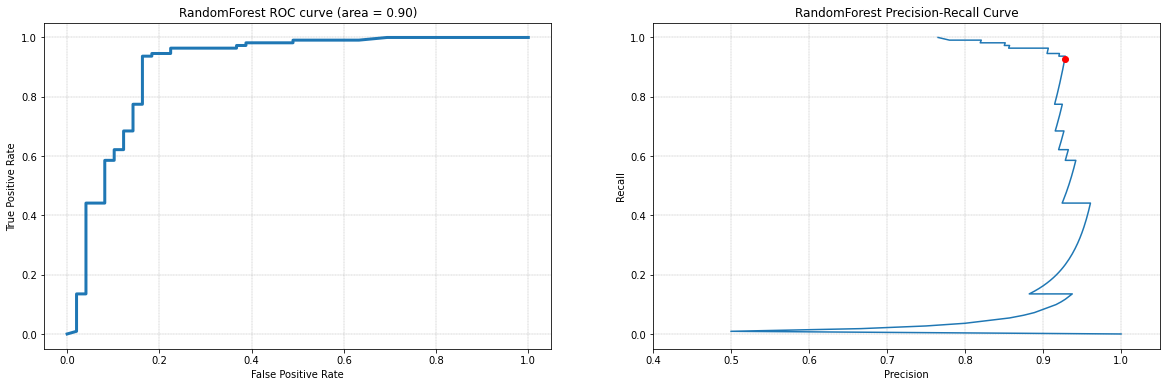

<Figure size 864x360 with 0 Axes>

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<AxesSubplot:ylabel='fi'>

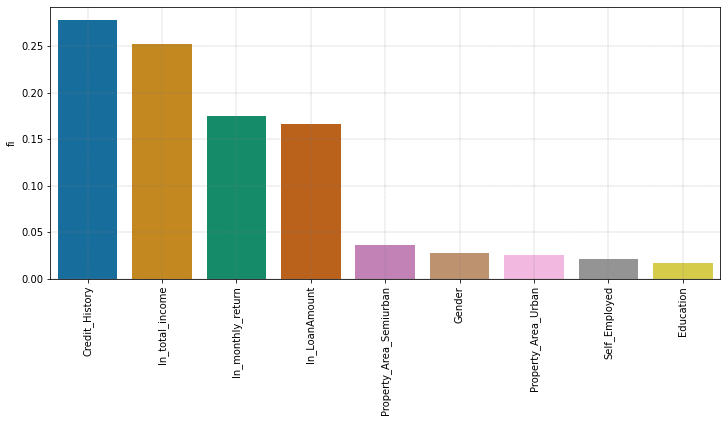

In [39]:
rf = model_training(RandomForestClassifier(random_state=42, 
                                           n_jobs=4, 
                                           n_estimators=50, 
                                           max_depth=max_depth,
                                           max_features=max_features),data_set)

t=data_set.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                     data_set['Loan_Status'],
                                                     test_size=ts,
                                                     stratify=data_set['Loan_Status'])

mod_eval(data_set, rf.predict(X_test), rf.predict_proba(X_test), y_test, 'RandomForest')
fi_df = pd.DataFrame({'fi': rf.feature_importances_},index=t.columns).sort_values(by='fi', ascending=False)
fi_df
plt.show()
plt.figure(figsize=(12,5))
plt.xticks(rotation='vertical')
sns.barplot(x=fi_df.index, y=fi_df['fi'], palette=current_palette)
plt.grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')
plt.show()

# LogisticRegression

              precision    recall  f1-score   support

           0       0.60      0.71      0.65        49
           1       0.86      0.79      0.83       111

    accuracy                           0.77       160
   macro avg       0.73      0.75      0.74       160
weighted avg       0.78      0.77      0.77       160



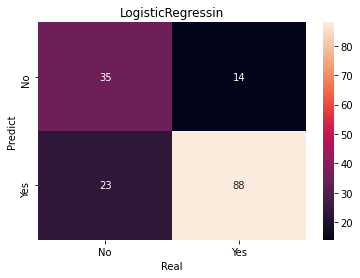

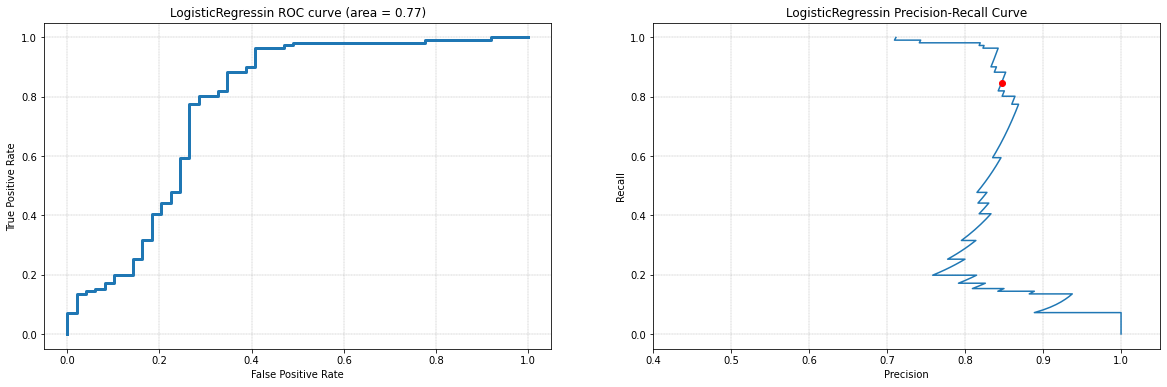

In [40]:
lr = model_training(LogisticRegression(C=lr_C, 
                                       penalty=penalty,
                                       solver='liblinear',
                                       max_iter=1000),data_set)

t=data_set.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    data_set['Loan_Status'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=data_set['Loan_Status'])

t = 0.71
predprob = lr.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]

#pred_y = lr.predict(X_test)
mod_eval(data_set, pred_y, lr.predict_proba(X_test), y_test, 'LogisticRegressin') 
plt.show()

# NaiveBayes

              precision    recall  f1-score   support

           0       0.69      0.63      0.66        49
           1       0.84      0.87      0.86       111

    accuracy                           0.80       160
   macro avg       0.77      0.75      0.76       160
weighted avg       0.80      0.80      0.80       160



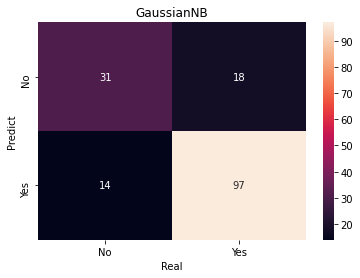

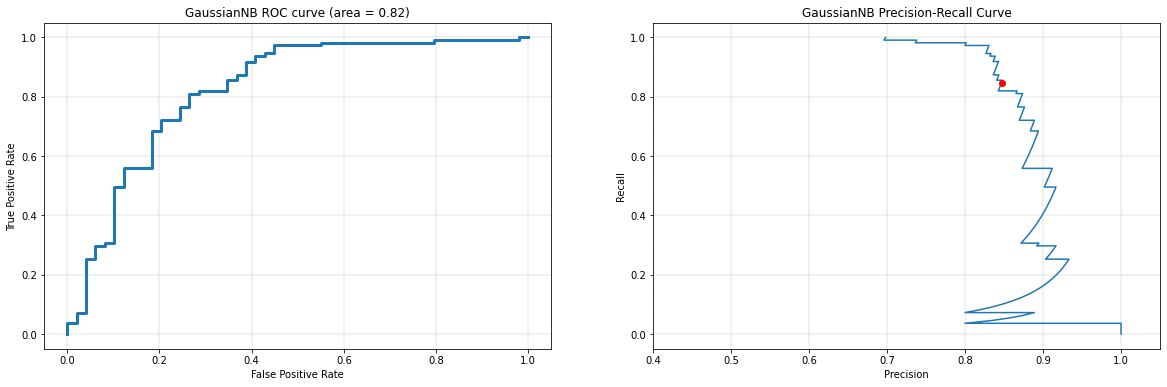

In [41]:
gnb = model_training(GaussianNB(),data_set)

t=data_set.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    data_set['Loan_Status'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=data_set['Loan_Status'])


t = 0.75
predprob = gnb.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
#pred_y = gnb.predict(X_test)
mod_eval(data_set,pred_y, gnb.predict_proba(X_test), y_test, 'GaussianNB')
plt.show()

# SVC

t=0.75
              precision    recall  f1-score   support

           0       0.63      0.65      0.64        49
           1       0.84      0.83      0.84       111

    accuracy                           0.78       160
   macro avg       0.74      0.74      0.74       160
weighted avg       0.78      0.78      0.78       160



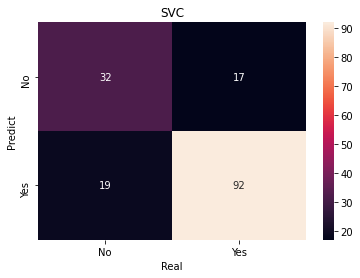

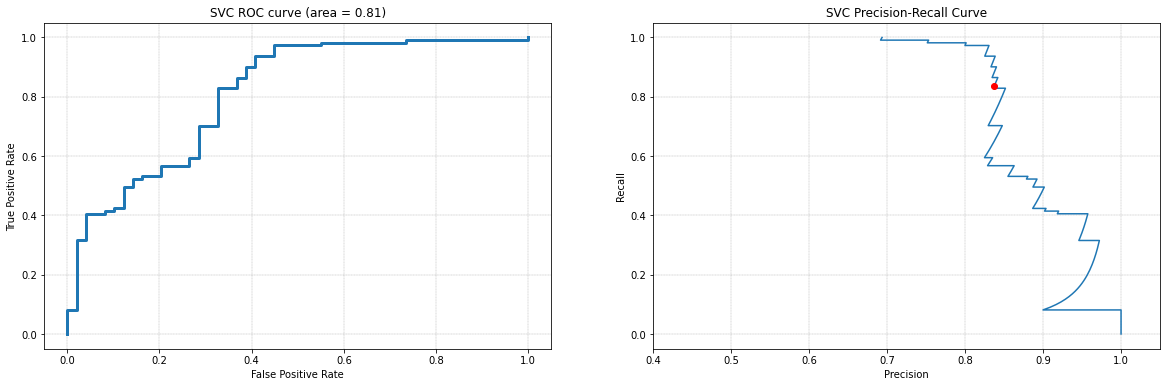

In [42]:
svc = model_training(SVC(kernel='linear',
                         C=1, 
                         gamma='auto',
                         class_weight='balanced',
                         probability=True),data_set)


t=data_set.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    data_set['Loan_Status'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=data_set['Loan_Status'])

t=0.75
print('t={}'.format(t))
predprob = svc.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
#pred_y = svc.predict(X_test)

mod_eval(data_set,pred_y, svc.predict_proba(X_test), y_test, 'SVC')
plt.show()

# Dummy

              precision    recall  f1-score   support

           0       0.27      0.29      0.28        49
           1       0.68      0.66      0.67       111

    accuracy                           0.54       160
   macro avg       0.47      0.47      0.47       160
weighted avg       0.55      0.54      0.55       160



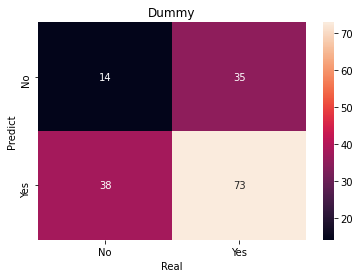

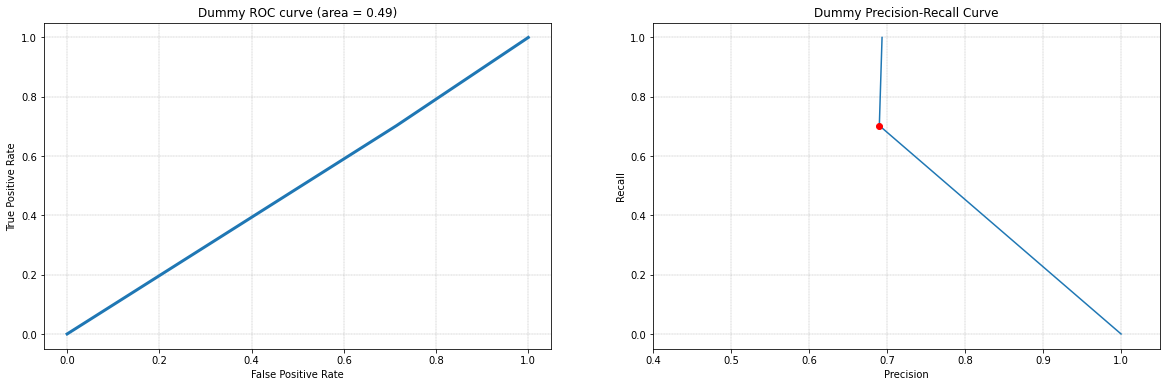

In [43]:
dummy = model_training(DummyClassifier(strategy='stratified'),data_set)

t=data_set.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    data_set['Loan_Status'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=data_set['Loan_Status'])

t = 0.5
predprob = dummy.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
#pred_y = dummy.predict(X_test)

mod_eval(data_set, pred_y, dummy.predict_proba(X_test), y_test, 'Dummy')
plt.show()